# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as wg
import sys
sys.path.append("../src")
from support import readFileDialog, function_from_file

# Functions

In [2]:
def readFileVicon(file_path, prefix="Victor:", keypoints_mapping_Vicon=None, first_line="Trajectories"):
    if keypoints_mapping_Vicon == None:
        keypoints_mapping_Vicon = ["LANK", "LKNE", "LTHI", "LASI", "LSHO", "LELB", "LWRB", "RANK", "RKNE", "RTHI", "RASI", "RSHO", "RELB", "RWRB"]
    metadata = pd.read_csv(file_path, nrows=1)
    fps = pd.read_csv(file_path, nrows=1)[first_line][0]
    keypoints_mapping_Vicon_tmp = pd.read_csv(file_path, skiprows=[0,1], nrows=1, header=None).values.tolist()[0]
    vicon_data = np.array(pd.read_csv(file_path, skiprows=[0,1,2,4]))
    keypoints_Vicon = np.zeros([len(vicon_data), len(keypoints_mapping_Vicon), 3])
    for i in range(len(keypoints_mapping_Vicon)):
        idx = keypoints_mapping_Vicon_tmp.index(prefix + keypoints_mapping_Vicon[i])
        keypoints_Vicon[:, i, :] = vicon_data[:, idx:idx+3]
    return keypoints_Vicon, keypoints_mapping_Vicon, fps

In [3]:
def plot3DPose(keypoints_Vicon, frame_n=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    kp_left = keypoints_Vicon[frame_n, :int(keypoints_Vicon.shape[1]/2), :]
    kp_right = keypoints_Vicon[frame_n, int(keypoints_Vicon.shape[1]/2):, :]
    kp_center = (kp_left[2:4, :] + kp_right[2:4, :])/2
    ax.plot([kp_left[2, 0], kp_right[2, 0]], [kp_left[2, 1], kp_right[2, 1]],zs=[kp_left[2, 2], kp_right[2, 2]], color='b')
    ax.plot([kp_left[3, 0], kp_right[3, 0]], [kp_left[3, 1], kp_right[3, 1]],zs=[kp_left[3, 2], kp_right[3, 2]], color='b')
    ax.plot([kp_center[0, 0], kp_center[1, 0]], [kp_center[0, 1], kp_center[1, 1]],zs=[kp_center[0, 2], kp_center[1, 2]], color='b')
    for i in range(int(keypoints_Vicon.shape[1]/2)-1):
        ax.plot([kp_left[i, 0], kp_left[i+1, 0]], [kp_left[i, 1], kp_left[i+1, 1]],zs=[kp_left[i, 2], kp_left[i+1, 2]], color='black')
        ax.plot([kp_right[i, 0], kp_right[i+1, 0]], [kp_right[i, 1], kp_right[i+1, 1]],zs=[kp_right[i, 2], kp_right[i+1, 2]], color='black')
    ax.scatter(kp_left[:, 0], kp_left[:, 1], kp_left[:, 2], marker='o', color='g')
    ax.scatter(kp_right[:, 0], kp_right[:, 1], kp_right[:, 2], marker='o', color='r')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    x, y, z = kp_right[:, 0], kp_right[:, 1], kp_right[:, 2]
    max_range = np.array([x.max()-x.min(), y.max()-y.min(),
                          z.max()-z.min()]).max() / 2.0
    mean_x = x.mean()
    mean_y = y.mean()
    mean_z = z.mean()
    ax.set_xlim(mean_x - max_range, mean_x + max_range)
    ax.set_ylim(mean_y - max_range, mean_y + max_range)
    ax.set_zlim(mean_z - max_range, mean_z + max_range)

    plt.show()

In [4]:
def interactive3DPose(keypoints_Vicon):    
    frame_slider = wg.IntSlider(value=0, min=0, max=len(keypoints_Vicon))
    def interactive3DPlot(frame_n):
        plot3DPose(keypoints_Vicon, frame_n)
    out = wg.interactive_output(interactive3DPlot, {'frame_n': frame_slider})
    display(frame_slider, out)

In [5]:
def getAngleLimited(A, B, O):
    try:
        ang = math.degrees(math.atan2(B[1]-O[1], B[0]-O[0]) - math.atan2(A[1]-O[1], A[0]-O[0]))
        if ang < 0:
            ang += 360
        if ang > 180:
            ang = 360 - ang
    except:
        ang = 0
    return ang

In [6]:
def inverseKinematicsRowing(keypoints):
    """ Expected joint order
    if orientation == "Sagittal Right":
        joints_order = ["Right Ankle", "Right Knee", "Right Hip", "Right Shoulder", "Right Elbow", "Right Wrist"]
    else:
        joints_order = ["Left Ankle", "Left Knee", "Left Hip", "Left Shoulder", "Left Elbow", "Left Wrist"]
    """
    angles = np.zeros(5)
    for i in range(5):
        if i == 0:
            O = keypoints[i]
            B = keypoints[i+1]
            C = keypoints[i+2]
            A = np.array([C[0], O[1]])
        else:
            A = keypoints[i-1]
            O = keypoints[i]
            B = keypoints[i+1]
            
        angles[i] = getAngleLimited(A, B, O)
        if i==3:
            if A[0] > B[0]:
                angles[i] = -angles[i]
    return angles

In [7]:
def get3DAngleLimited(A, O, B):
    f = O-A 
    e = O-B 
    AOVec = np.linalg.norm(f)
    OBVec = np.linalg.norm(e)
    AONorm = f / AOVec
    OBNorm = e / OBVec
    res = AONorm[0] * OBNorm[0] + AONorm[1] * OBNorm[1] + AONorm[2] * OBNorm[2]
    ang = math.degrees(np.arccos(res))
    if ang < 0:
        ang += 360
    if ang > 180:
        ang = 360 - ang
    return ang

In [8]:
def inverseKinematicsRowing3D(keypoints):
    angles_SL = np.zeros(5)
    angles_SR = np.zeros(5)
    for i in range(len(angles_SL)):
        if i == 0:
            O_SL, O_SR= keypoints[i], keypoints[i+len(angles_SL)]
            B_SL, B_SR = keypoints[i+1], keypoints[i+1+len(angles_SL)]
            C_SL, C_SR = keypoints[i+2], keypoints[i+2+len(angles_SL)]
            A_SL, A_SR = np.array([C_SL[0], O_SL[1], O_SL[2]]), np.array([C_SR[0], O_SR[1], O_SR[2]])
        else:
            A_SL, A_SR = keypoints[i-1], keypoints[i-1+len(angles_SL)]
            O_SL, O_SR = keypoints[i], keypoints[i+len(angles_SL)]
            B_SL, B_SR = keypoints[i+1], keypoints[i+1+len(angles_SL)]
        angles_SL[i] = get3DAngleLimited(A_SL, O_SL, B_SL)      
        angles_SR[i] = get3DAngleLimited(A_SR, O_SR, B_SR)
        if i==3:
            if A_SL[0] < B_SL[0]:
                angles_SL[i] = -angles_SL[i]
            if A_SR[0] > B_SR[0]:
                angles_SR[i] = -angles_SR[i]
    angles_S = np.append(angles_SL, angles_SR)
    return angles_S, angles_SL, angles_SR

In [9]:
def get3DAnglesVector(keypoints_Vicon, keypoints_mapping_Vicon=None):
    if keypoints_mapping_Vicon == None:
            keypoints_mapping_Vicon = ["LANK", "LKNE", "LASI", "LSHO", "LELB", "LWRB", "RANK", "RKNE", "RASI", "RSHO", "RELB", "RWRB"]
    angles_vec = np.zeros([len(keypoints_Vicon), len(keypoints_mapping_Vicon)-2])
    for i in range(len(keypoints_Vicon)):
        angles_S, angles_SL, angles_SR = inverseKinematicsRowing3D(keypoints_Vicon[i])
        angles_vec[i, :int(len(keypoints_mapping_Vicon)/2)-1] = angles_SL
        angles_vec[i, int(len(keypoints_mapping_Vicon)/2)-1:] = angles_SR
    return angles_vec

In [10]:
def get2DAnglesVector(keypoints_Vicon_2D, keypoints_mapping_Vicon=None):
    if keypoints_mapping_Vicon == None:
            keypoints_mapping_Vicon = ["ANK", "KNE", "HIP", "SHO", "ELB", "WRI"]
    angles_vec = np.zeros([len(keypoints_Vicon), len(keypoints_mapping_Vicon)-1])
    for i in range(len(keypoints_Vicon)):
        angles = inverseKinematicsRowing(keypoints_Vicon_2D[i])
        angles_vec[i, :] = angles
    return angles_vec

In [11]:
def showRowingChainAnglesPlot(keypoints_xy): 
    """ Expected joint order
    if orientation == "Sagittal Right":
        joints_order = ["Right Ankle", "Right Knee", "Right Hip", "Right Shoulder", "Right Elbow", "Right Wrist"]
    else:
        joints_order = ["Left Ankle", "Left Knee", "Left Hip", "Left Shoulder", "Left Elbow", "Left Wrist"]
    """
    angles = inverseKinematicsRowing(keypoints_xy)
    
    plt.figure()
    for i in range(5):
        O = keypoints_xy[i]
        B = keypoints_xy[i+1]          
        plt.plot([O[0], B[0]], [O[1], B[1]], 'ro-', color = "black")
        circle1 = plt.Circle((O[0], O[1]), 1, color='r')
        plt.text(O[0], O[1], "{}".format(int(round(angles[i]))), bbox=dict(facecolor='red', alpha=0.5))
        plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show()

# Open File

In [14]:
file_path = readFileDialog("Open Vicon file")
file_path

'C:/Users/victo/Documents/Motion_analysis/Vicon/Victor_Vicon/Victor Voga24_5min.csv'

In [15]:
keypoints_Vicon, keypoints_mapping_Vicon, fps = readFileVicon(file_path, prefix="Victor:")

In [23]:
np.any(np.isnan(keypoints_Vicon[500, int(keypoints_Vicon.shape[1]/2):]))

False

In [16]:
kp_right = keypoints_Vicon[500, int(keypoints_Vicon.shape[1]/2):]

In [24]:
np.any(np.isnan(kp_right))

False

In [25]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# kp_left = keypoints_Vicon[frame_n, :int(keypoints_Vicon.shape[1]/2), :]
# kp_right = keypoints_Vicon[frame_n, int(keypoints_Vicon.shape[1]/2):, :]
# kp_center = (kp_left[2:4, :] + kp_right[2:4, :])/2
# ax.plot([kp_left[2, 0], kp_right[2, 0]], [kp_left[2, 1], kp_right[2, 1]],zs=[kp_left[2, 2], kp_right[2, 2]], color='b')
# ax.plot([kp_left[3, 0], kp_right[3, 0]], [kp_left[3, 1], kp_right[3, 1]],zs=[kp_left[3, 2], kp_right[3, 2]], color='b')
# ax.plot([kp_center[0, 0], kp_center[1, 0]], [kp_center[0, 1], kp_center[1, 1]],zs=[kp_center[0, 2], kp_center[1, 2]], color='b')
ax.scatter(kp_right[:, 0], kp_right[:, 1], kp_right[:, 2], marker='o', color='r')
for i in range(kp_right.shape[0]-1):
#     ax.plot([kp_left[i, 0], kp_left[i+1, 0]], [kp_left[i, 1], kp_left[i+1, 1]],zs=[kp_left[i, 2], kp_left[i+1, 2]], color='g')
    ax.plot([kp_right[i, 0], kp_right[i+1, 0]], [kp_right[i, 1], kp_right[i+1, 1]],zs=[kp_right[i, 2], kp_right[i+1, 2]], color='black')
# ax.scatter(kp_left[:, 0], kp_left[:, 1], kp_left[:, 2], marker='o', color='g')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# Fix aspect ratio
x, y, z = kp_right[:, 0], kp_right[:, 1], kp_right[:, 2]
max_range = np.array([x.max()-x.min(), y.max()-y.min(),
                      z.max()-z.min()]).max() / 2.0
mean_x = x.mean()
mean_y = y.mean()
mean_z = z.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 3D Analysis

In [19]:
%matplotlib widget
interactive3DPose(keypoints_Vicon)

IntSlider(value=0, max=18976)

Output()

In [96]:
angles_vec = get3DAnglesVector(keypoints_Vicon, keypoints_mapping_Vicon=None)

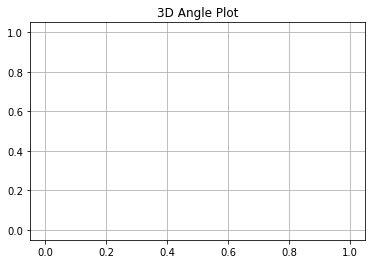

In [97]:
%matplotlib inline
t = np.linspace(0, len(keypoints_Vicon)*(1/fps), len(keypoints_Vicon))
plt.figure()
plt.plot(t, angles_vec[:, 4])
plt.title("3D Angle Plot")
plt.grid(True)
plt.show()

# 2D Analysis

Assuming a fixed volume origin, we can get the 2D sagittal plane simply by removing the X component of the trajectory, as seen in the 3D trajectory plot. Then, for the analysis we separate left sagittal plane.

In [98]:
keypoints_mapping_SL = ['Left Ankle','Left Knee','Left Hip','Left Shoulder','Left Elbow','Left Wrist']
keypoints_Vicon_2D = np.copy(keypoints_Vicon[:,:len(keypoints_mapping_SL),1:])

ValueError: cannot convert float NaN to integer

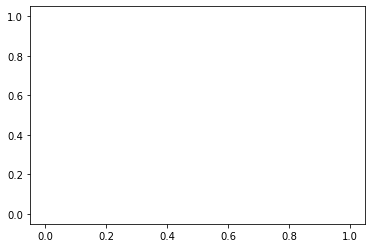

In [99]:
%matplotlib inline
frame_n = 0
showRowingChainAnglesPlot(keypoints_Vicon_2D[frame_n])
angles = inverseKinematicsRowing(keypoints_Vicon_2D[frame_n])
print(angles)

In [17]:
angles_vec_2D = get2DAnglesVector(keypoints_Vicon_2D, keypoints_mapping_Vicon=None)

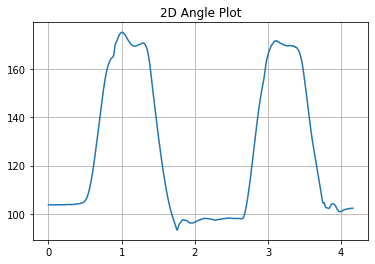

In [18]:
%matplotlib inline
t = np.linspace(0, len(keypoints_Vicon_2D)*(1/fps), len(keypoints_Vicon_2D))
plt.figure()
plt.plot(t, angles_vec_2D[:, 1])
plt.title("2D Angle Plot")
plt.grid(True)
plt.show()

# 2D vs 3D

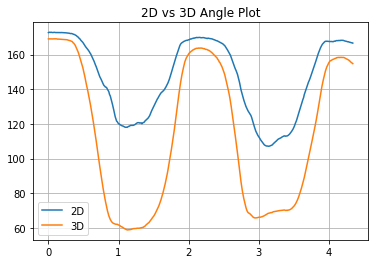

In [25]:
%matplotlib inline
joint_n = 4
t = np.linspace(0, len(keypoints_Vicon_2D)*(1/fps), len(keypoints_Vicon_2D))
plt.figure()
plt.plot(t, angles_vec_2D[:, joint_n], label='2D')
plt.plot(t, angles_vec[:, joint_n], label='3D')
plt.title("2D vs 3D Angle Plot")
plt.grid(True)
plt.legend()
plt.show()